In [15]:
import pennylane as qml
from pennylane import numpy as npp
from matplotlib import pyplot as plt

# set the random seed
npp.random.seed(42)

# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift", interface="autograd")
def circuit(params,inputs):
    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)
    qml.RY(inputs[2], wires=2)
    qml.RY(inputs[3], wires=3)
    
    
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)
    qml.RY(params[3], wires=3)
    
    qml.CRX(params[4], wires=[3,0])
    qml.CRX(params[5], wires=[2,3])
    qml.CRX(params[6], wires=[1,2])
    qml.CRX(params[7], wires=[0,1])
    
    qml.RY(params[8], wires=0)
    qml.RY(params[9], wires=1)
    qml.RY(params[10], wires=2)
    qml.RY(params[11], wires=3)
    
    qml.CRX(params[12], wires=[3,2])
    qml.CRX(params[13], wires=[0,3])
    qml.CRX(params[14], wires=[1,0])
    qml.CRX(params[15], wires=[2,1])

    #return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)@ qml.PauliZ(2)@ qml.PauliZ(3))
    return qml.expval(qml.PauliX(0) @  qml.PauliY(2))

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split 
import scipy.stats as stats
import math

def norminv(x):
    return ((1.0/math.sqrt(2.0*math.pi)) * math.exp(-x*x*0.5))

def d1(S0, K, r, T, sigma, q):
    deno = (sigma * math.sqrt(T))
    if (deno==0):
        return 0
    logReturns = math.log(S0/float(K)) if ((S0/float(K)) > 0.0) else 0.0
    return (float(logReturns) + (float(r) - float(q) + float(sigma)*float(sigma)*0.5)*float(T)) / float(deno)
    
def d2(S0, K, r, T, sigma, q):
        return d1(S0, K, r, T, sigma, q)-sigma*math.sqrt(T)
        
def bsformula(callput, S0, K, r, T, sigma, q=0):
    N = stats.norm.cdf
                
    def optionValueOfCall(S0, K, r, T, sigma, q):       
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return S0*math.exp(-q*T)*N(_d1)- K*math.exp(-r*T)*N(_d2)
      
    def optionValueOfPut(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return float(K)*math.exp(-float(r)*float(T))*N(-_d2) - float(S0)*math.exp(-float(q)*float(T))*N(-_d1)
        
    def delta(callput, S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)        
        if callput.lower() == "call":            
            return N(_d1) * math.exp(-q*T)
        else:
            return (N(_d1)-1)* math.exp(-q*T)
    
    def vega(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        return S0  * math.sqrt(T) * norminv(_d1)  * math.exp(-q*T)
    
    if callput.lower()=="call":
        optionValue = optionValueOfCall(S0, K, r, T, sigma, q)
    else:
        optionValue = optionValueOfPut(S0, K, r, T, sigma, q)
        
    _delta = delta(callput, S0, K, r, T, sigma, q)
    _vega = vega(S0, K, r, T, sigma, q)
    
    return (optionValue, _delta, _vega)

def bsm_iv_generator(num_sample = 100,tao_bound=[0.01,2.0],  sigma_bound=[0.01,2.0], 
                     money_bound=[0.3,3.0], rr_bound=[0.01,0.2], callput='call', seed=42):
    
    # input parameters: when callput is not in 'call' or 'put', randomly generate the option price followed by root-finding methods to
    # compute the corresponding implied vol
    # return: X_input = [time,stock,rr, dividen, option_price]. Y_outpu  = volatility 
    np.random.seed(seed)
    tao_min,tao_max = tao_bound[0],tao_bound[1]
    
    sigma_min, sigma_max = sigma_bound[0],sigma_bound[1]
    moneyness_min,moneyness_max = money_bound[0],money_bound[1]
    rr_min,rr_max = rr_bound[0],rr_bound[1]
   
    

    num_sample = int(num_sample)
    xx = np.zeros([num_sample,4],dtype='float')
    
   
    xx[:,0] = np.random.uniform(sigma_min, sigma_max,xx.shape[0])
    xx[:,1] = np.random.uniform(tao_min,tao_max,xx.shape[0])
    xx[:,2] = np.random.uniform(moneyness_min,moneyness_max,xx.shape[0])
    xx[:,3] = np.random.uniform(rr_min,rr_max,xx.shape[0])
   
    
   
    strike=1.0 #fixed strike
    #callput = 'call' # call option
    v = np.zeros(xx.shape[0]) # option value
    k = np.ones(xx.shape[0]) # strike price, just in order to match the shape of v
    
    if callput in ['call','put']:        
        for i in range(0,xx.shape[0]):        
            sigma, T, S0, interest = xx[i,0],xx[i,1],xx[i,2],xx[i,3]
            ## use the Black-Schole function in compfin.py
            v[i] = bsformula(callput, S0, strike, interest, T, sigma)[0]              
            
  
    v= v.reshape(xx.shape[0],1)     
    xx_sample = np.concatenate((xx,v),axis=1) #sigma, time, s, r, v
    
    
    X_input   = xx_sample[:,1:]   # time,stock,rr, option_price
    Y_output  =  xx_sample[:,0] # sigma -implied volatility is the predictive variable.
  
    return X_input,Y_output
#  log-transformation of the option value
def logscale_vol(x_train_dat,y_train_dat,otm_lower=0.0000001):
   # input data: x_train_dat = [time,stock,rr, option_price], y_train_dat = sigma  
   
    xtv_train_log=x_train_dat.copy()    
    ytv_train_log =y_train_dat.copy()
    
    
    #v_lower[v_lower<0.0]=0.0 # V=max(S-E*exp(-rt),0)  
    xintrinsic_train=xtv_train_log[:,1]-1.0*np.exp(-1.0*xtv_train_log[:,2]*xtv_train_log[:,0])
    xintrinsic_train[xintrinsic_train<0.0]=0.0 ## \tilde{V} = max(S-E*exp(-rt),0)
    xtv_train_log[:,-1] = xtv_train_log[:,-1] -xintrinsic_train
    
    ## remove intrisinc values below the threshold (otm_lower \approx machine pricision)  
   
    ytv_train_log = ytv_train_log[~np.less(xtv_train_log[:,-1],otm_lower)]
    xtv_train_log = xtv_train_log[~np.less(xtv_train_log[:,-1],otm_lower),:]
    xtv_train_log[:,-1]=np.log(xtv_train_log[:,-1])

    return xtv_train_log,ytv_train_log 

maturity time  range:
0.5005522117123602 0.5986886936600517
Stock price  range:
0.9802780852212476 1.0188712833088385
interest rate  range:
0.030829391446392806 0.07928252270553005
option value  range:
0.09746900812834913 0.21773104905666268
sigma range:
0.308233797718321 0.6879639408647977
(50, 4)
maturity time  range:
0.5005522117123602 0.5986886936600517
Stock price  range:
0.9802780852212476 1.0188712833088385
interest rate  range:
0.030829391446392806 0.07928252270553005
time option-value  range:
-2.614763769983766 -1.672877716398405
sigma range:
0.308233797718321 0.6879639408647977
(40, 4)
Parameters: [0.64203165 0.08413996 0.16162871 0.89855419 0.60642906 0.00919705
 0.10147154 0.66350177 0.00506158 0.16080805 0.54873379 0.6918952
 0.65196126 0.22426931 0.71217922 0.23724909]
inputs: [0.3253997  0.74649141 0.6496329  0.84922341]
Expectation value: -0.14090773264118472


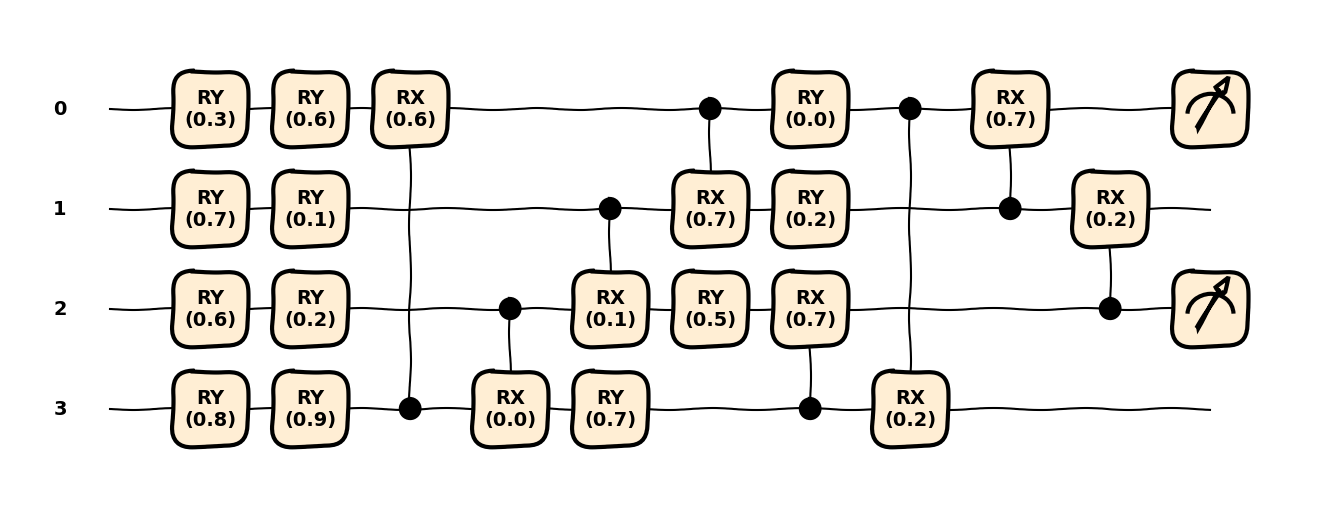

In [19]:
Xin_input,Yin_output=bsm_iv_generator(num_sample = 50,tao_bound=[0.5,0.6],  sigma_bound=[0.3,0.7], 
                                      money_bound=[0.98,1.02], rr_bound=[0.03,0.08],callput='call')

#check the data value range on each dimension
## xin = [maturity time, Stock price, interest rate, dividend, option value]

xlabel =  ['maturity time', 'Stock price', 'interest rate','option value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(Xin_input[:,i]),np.max(Xin_input[:,i]))
    
print('sigma range:')
print(np.min(Yin_output),np.max(Yin_output))
print(np.shape(Xin_input))

# generate and shuffle the data set into training and test part
xtv_train_log_all,ytv_train_log_all=logscale_vol(Xin_input,Yin_output,otm_lower=1e-4)
'''
for i in range(4):
    xtv_train_log_all[:,i]= min_max_normalization(xtv_train_log_all[:,i])
'''
#ytv_train_log_all=ytv_train_log_all/2
xtv_train_log,xtv_test_log, ytv_train_log, ytv_test_log   = train_test_split(xtv_train_log_all,ytv_train_log_all,test_size=0.2,random_state=42)

xlabel =  ['maturity time', 'Stock price', 'interest rate','time option-value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(xtv_train_log_all[:,i]),np.max(xtv_train_log_all[:,i]))
    
print('sigma range:')
print(np.min(ytv_train_log),np.max(ytv_train_log))
## how many samples after cleaning
print(np.shape(xtv_train_log))


params = npp.random.random([16], requires_grad=True)
inputs = npp.random.random([4], requires_grad=True)
print("Parameters:", params)
print("inputs:", inputs)
print("Expectation value:", circuit(params,inputs))


qnode = qml.QNode(circuit, dev)
qml.draw_mpl(circuit, decimals=1, style="sketch")(params,inputs)
plt.show()

In [20]:
def parameter_shift_term(qnode,params,inputs, i):
    shifted = params.copy()
    shifted[i] += np.pi/2
    forward = qnode(shifted,inputs)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted,inputs) # backward evaluation

    return 0.5 * (forward - backward)

# gradient with respect to the first parameter
print(parameter_shift_term(circuit,params,inputs, 0))


def parameter_shift(qnode, params,inputs):
    gradients = np.zeros([len(params)])

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode,params,inputs, i)

    return gradients

print(parameter_shift(circuit, params,inputs))

grad_function = qml.grad(circuit)
print(grad_function(params,inputs)[0])


print(qml.gradients.param_shift(circuit)(params,inputs)[0])

-0.12496682370212822
[-0.12496682 -0.05646137  0.35299219 -0.02585693  0.03172171 -0.24633726
 -0.02222807  0.08096439 -0.1067693  -0.04649079  0.34789626 -0.03744824
 -0.09667625  0.03108379  0.02654649 -0.3293877 ]
[-0.12496682 -0.05646137  0.35299219 -0.02585693  0.02754679 -0.17159644
 -0.03521268  0.05873467 -0.1067693  -0.04649079  0.34789626 -0.03744824
 -0.09685749  0.02197956  0.0187712  -0.23291227]
[-0.12496682 -0.05646137  0.35299219 -0.02585693  0.02754679 -0.17159644
 -0.03521268  0.05873467 -0.1067693  -0.04649079  0.34789626 -0.03744824
 -0.09685749  0.02197956  0.0187712  -0.23291227]


In [21]:
from sklearn import metrics
from itertools import chain
import time
def QNN(weights, angles):
    return circuit(weights, angles)

def cost(weights, features, labels):
    predictions = [QNN(weights, f) for f in features]
    
    return square_loss(labels, predictions)

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def R2(labels, predictions):

    r2 = 0
    for l, p in zip(labels, predictions):
        r2 = r2 + metrics.r2_score(labels, predictions)
    r2 = r2 / len(labels)

    return r2

In [22]:
X=xtv_train_log
Y=ytv_train_log
weights_init = npp.random.random([16], requires_grad=True)
opt = qml.AdamOptimizer(0.01)
batch_size = 20
batches = len (X) // batch_size
X_batches = npp.array_split(npp.arange(len(X)) , batches)


epoch 1
-------------------------------
batch_idx: 0 loss: 0.3495551549035029 R2: -23.81814160275175 time: 1703268072.5934045
batch_idx: 1 loss: 0.3537722879927364 R2: -23.02058054937311 time: 1703268078.9485323
Training [0%] Loss: 0.35166372144811964 time: 1703268078.9485323
weight: [ 0.62204422  0.06416838  0.1416252   0.91849996  0.58642826  0.0291532
  0.08147844  0.68348663 -0.01493326  0.14081297  0.52872286  0.71183775
  0.63198494  0.20430276  0.73215101  0.21726404]
epoch 2
-------------------------------
batch_idx: 0 loss: 0.32723909501607046 R2: -22.272738089118125 time: 1703268085.3185778
batch_idx: 1 loss: 0.3330267109541548 R2: -21.575230158282004 time: 1703268091.6335137
Training [1%] Loss: 0.33013290298511266 time: 1703268091.6335137
weight: [ 0.60218969  0.04444317  0.12202743  0.93828932  0.56641423  0.04894255
  0.06156017  0.7033034  -0.03480326  0.12089063  0.50874018  0.73162742
  0.61212319  0.18442541  0.75190118  0.19740055]
epoch 3
----------------------------

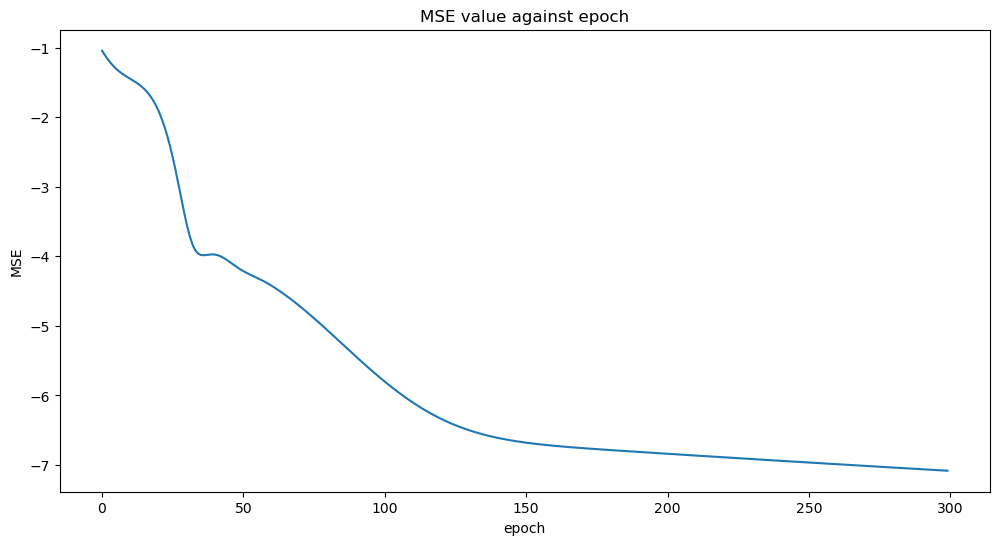

In [23]:
'''
weights =[0.68756473 , 1.2864305 ,  0.5411694 , -0.01524038 , 0.5852044 ,  0.6762012,
  0.35593897 , 0.22628789,  0.38244092,  0.35140917,  0.86482936 , 0.8531242,
  0.09241156 , 0.6720707  , 0.38071635,  0.95416117 , 0.63409   ,  0.40179932,
  0.7345088  , 0.6243114  , 0.3178202 , -0.2618623  , 0.18122938,  1.0447433,
  0.48699683 , 0.7739934  , 0.38703147 , 0.48046085,  0.5525667 ,  0.52838504,
  0.28538367 , 0.30099392,  0.74503726 , 0.67772216,  0.3839896 ,  0.417687]
weights = npp.array(weights, requires_grad=True)
'''
weights = params
loss_list=[]
r2_list=[]

n_epochs=300

start_time=time.time()
for epoch in range(n_epochs):
    total_loss  = []
    total_r2  = []
    print(f"epoch {epoch+1}\n-------------------------------")
    for it, batch_index in enumerate (chain(*[X_batches])):
        # Update the weights by one optimizer step
        
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        weights, _, _ = opt.step(cost, weights, X_batch, Y_batch)

        # Compute accuracy
        predictions = [QNN(weights, x) for x in X]
        r2 = R2(Y, predictions)
        cost_t=cost(weights,X_batch,Y_batch)
        total_loss.append(cost_t)
        total_r2.append(r2)
        end_timet=time.time()
        print("batch_idx:",it,"loss:",cost_t,"R2:",r2,"time:",end_timet)
    loss_list.append(sum(total_loss)/len(total_loss))
    r2_list.append(sum(total_r2)/len(total_r2))
    print('Training [{:.0f}%]'.format(100. * (epoch + 1) / n_epochs),"Loss:", loss_list[-1], "time:",end_timet)
    print("weight:",weights)
    
    
predictions = [QNN(weights, x) for x in X]

train_R2 = R2(Y, predictions)
train_MSE=metrics.mean_squared_error(Y,predictions)
train_RMSE=train_MSE**(1/2)
train_MAE=metrics.mean_absolute_error(Y,predictions)
train_MAPE=metrics.mean_absolute_percentage_error(Y,predictions)

print("train_MSE:",train_MSE)
print("train_RMSE:",train_RMSE)
print("train_MAE:",train_MAE)
print("train_MAPE:",train_MAPE)
print("train_R2:",train_R2)

plt.rcParams["figure.figsize"] = (12, 6)

plt.title("MSE value against epoch")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.plot(range(len(loss_list)), np.log(loss_list))
plt.show()

In [ ]:
X_test=xtv_test_log
Y_test=ytv_test_log
test_predictions = [QNN(weights, x) for x in X_test]

test_R2 = R2(Y_test, test_predictions)
test_MSE=metrics.mean_squared_error(Y_test,test_predictions)
test_RMSE=test_MSE**(1/2)
test_MAE=metrics.mean_absolute_error(Y_test,test_predictions)
test_MAPE=metrics.mean_absolute_percentage_error(Y_test,test_predictions)

print("test_MSE:",test_MSE)
print("test_RMSE:",test_RMSE)
print("test_MAE:",test_MAE)
print("test_MAPE:",test_MAPE)
print("test_R2:",test_R2)